# Train

In [1]:
import os 
import torch

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from torch.utils.data import Dataset, DataLoader
from datachallengecode import load_data
from datachallengecode import metric

from torchmetrics import MeanMetric, Accuracy, F1Score

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
class2idx = {
    "background": 0,
    "beams": 1,
    "cabletrays": 2,
    "civils": 3,
    "gratings": 4,
    "guardrails": 5,
    "hvac": 6,
    "ladders": 7,
    "piping": 8,
    "supports": 9,
}

n_classes = len(class2idx)

In [3]:
data_path = "data"

ytrain_path = os.path.join(data_path, "ytrain.csv")
xtrain_path = os.path.join(data_path, "xtrain")

ytrain_map__path = os.path.join(data_path, "ytrain_map_ind_station.csv")

In [4]:
class PlyPointsDataset(Dataset):
    def __init__(self, data_path, station_id=0, cloud_size=2048, transform=None):
        ytrain_path = os.path.join(data_path, "ytrain.csv")
        xtrain_path = os.path.join(data_path, "xtrain")
        ply_file = os.path.join(xtrain_path, f"SCAN_{station_id}.ply")

        ytrain_map__path = os.path.join(data_path, "ytrain_map_ind_station.csv")
        
        _, x = load_data.read_x_plyfile(ply_file)
        rest = cloud_size - (x.shape[0] % cloud_size)
        x = np.concatenate([x, x[:rest, :]])
        x[:, :3] = x[:, :3] / (x[:, :3].max() - x[:, :3].min())
        x[:, 3:6] = x[:, 3:6] / 255
        x[:, 6] = x[:, 6] / 255
        self.x = x.reshape(-1, cloud_size, x.shape[-1]).transpose(0, 2, 1)
        
        y = load_data.load_yfile(ytrain_path)
        y_map = pd.read_csv(ytrain_map__path, header=None, names=["station_id", "point_id_low", "point_id_high"])
        y_map.set_index("station_id", inplace=True)
        low, high = y_map.iloc[station_id]
        y = y[low:high+1]
        y = np.concatenate([y, y[:rest]])
        self.y = y.reshape(-1, cloud_size)
        
        self.cloud_size = cloud_size
        self.station_id = station_id
        self.transform = transform
        
    def __len__(self):
        return self.y.shape[0]
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample = (self.x[idx], self.y[idx])
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample
    

def transform(sample):
    x, y = sample
    
    x = torch.from_numpy(x).to(DEVICE)
    y = torch.from_numpy(y).to(DEVICE)
    
    return (x, y)

In [5]:
def evaluate(net, dataloader, criterion):
    mean = MeanMetric()
    f1 = F1Score(num_classes=n_classes, mdmc_reduce="global")
    
    for i, (inputs, labels) in enumerate(tqdm(eval_dataloader), 0):
        with torch.no_grad():
            outputs, _ = net(inputs)
            
        preds = outputs.argmax(dim=1)
        
        loss = criterion(outputs, labels).item()
        mean.update(loss)
        f1.update(outputs, labels)
        
    return mean.compute(), f1.compute()

## PointNet++

In [6]:
from pointnet import PointNet

import torch.optim as optim
import torch.nn as nn

In [7]:
net = PointNet(num_classes=n_classes).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [8]:
train_dataset = PlyPointsDataset(data_path, station_id=0, transform=transform)
eval_dataset = PlyPointsDataset(data_path, station_id=1, transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
eval_dataloader = DataLoader(eval_dataset, batch_size=8, shuffle=False, num_workers=0)

In [9]:
losses = []
eval_losses = []
eval_f1s = []

log_steps = 50
mean = MeanMetric()
for epoch in range(10):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_dataloader, 0):
        optimizer.zero_grad()
        
        outputs, _ = net(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        mean.update(loss.item())
        
        running_loss += loss.item()
        if i % log_steps == log_steps-1:
            print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / log_steps:.3f}")
            running_loss = 0.0
        
    eval_loss, eval_f1 = evaluate(net, eval_dataloader, criterion)
    
    print(f"[{epoch + 1}, eval] loss: {eval_loss:.3f} f1:  {eval_f1:.3f}")
    
    losses.append(mean.compute())    
    eval_losses.append(eval_loss)
    eval_f1s.append(eval_f1)


[1,     1] loss: 0.050
[1,    51] loss: 1.557
[1,   101] loss: 1.071


  0%|          | 0/152 [00:00<?, ?it/s]

[1,   145] eval loss: 1.253 eval f1:  0.634
[2,     1] loss: 0.020
[2,    51] loss: 0.999
[2,   101] loss: 0.982


  0%|          | 0/152 [00:00<?, ?it/s]

[2,   145] eval loss: 1.216 eval f1:  0.635
[3,     1] loss: 0.019
[3,    51] loss: 0.963
[3,   101] loss: 0.955


  0%|          | 0/152 [00:00<?, ?it/s]

[3,   145] eval loss: 1.201 eval f1:  0.635
[4,     1] loss: 0.019
[4,    51] loss: 0.947
[4,   101] loss: 0.942


  0%|          | 0/152 [00:00<?, ?it/s]

[4,   145] eval loss: 1.190 eval f1:  0.635
[5,     1] loss: 0.019
[5,    51] loss: 0.937
[5,   101] loss: 0.935


  0%|          | 0/152 [00:00<?, ?it/s]

[5,   145] eval loss: 1.183 eval f1:  0.635
[6,     1] loss: 0.019
[6,    51] loss: 0.929
[6,   101] loss: 0.929


  0%|          | 0/152 [00:00<?, ?it/s]

[6,   145] eval loss: 1.179 eval f1:  0.635
[7,     1] loss: 0.019
[7,    51] loss: 0.926
[7,   101] loss: 0.925


  0%|          | 0/152 [00:00<?, ?it/s]

[7,   145] eval loss: 1.177 eval f1:  0.635
[8,     1] loss: 0.018
[8,    51] loss: 0.922
[8,   101] loss: 0.921


  0%|          | 0/152 [00:00<?, ?it/s]

[8,   145] eval loss: 1.174 eval f1:  0.635
[9,     1] loss: 0.019
[9,    51] loss: 0.920
[9,   101] loss: 0.919


  0%|          | 0/152 [00:00<?, ?it/s]

[9,   145] eval loss: 1.173 eval f1:  0.635
[10,     1] loss: 0.018
[10,    51] loss: 0.916
[10,   101] loss: 0.916


  0%|          | 0/152 [00:00<?, ?it/s]

[10,   145] eval loss: 1.172 eval f1:  0.635


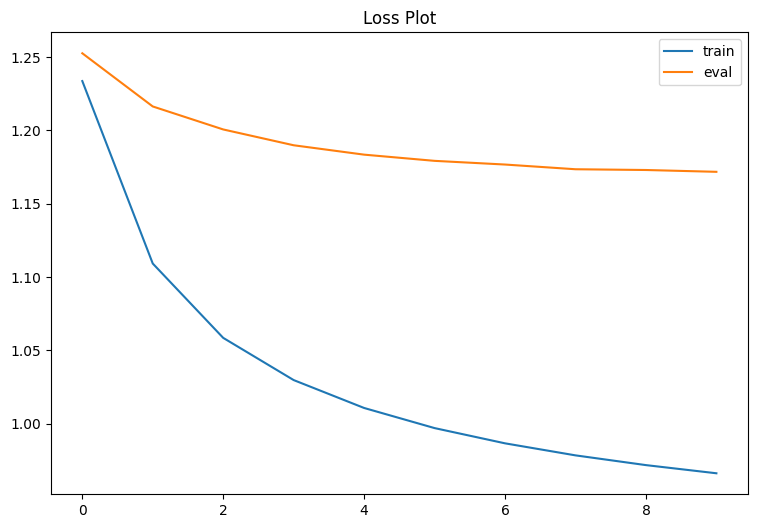

In [10]:
fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(losses, label="train")
ax.plot(eval_losses, label="eval")

plt.legend()
plt.title("Loss Plot")
plt.show()

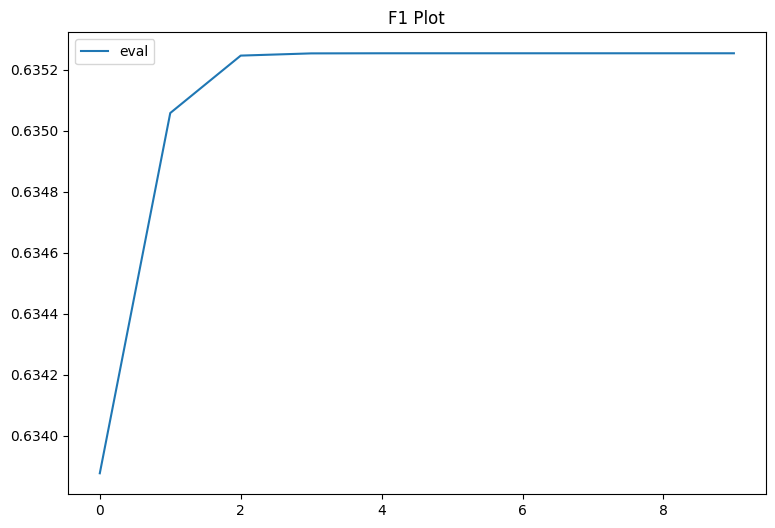

In [11]:
fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(eval_f1s, label="eval")

plt.legend()
plt.title("F1 Plot")
plt.show()